# Figure: sensitivity analysis results
This script generates figure XX of the paper, giving the sensitivity analysis benchmarking results

### Before you start
This notebook assumes that the sensitivity analysis runs have been completed and evaluated, with evaluated metrics located in `MCSPACE_paper/sensitivity_analysis`.

Refer to the README in `MCSPACE_paper/scripts` for the analysis pipeline and more details.

In [1]:
from mcspace.utils import pickle_load
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.patches as mpatches
import matplotlib as mpl
import numpy as np

from statsmodels.stats.multitest import multipletests
from scipy.stats import mannwhitneyu
import matplotlib.patches as mpatches

In [2]:
# change font
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['svg.fonttype'] = 'none'

# Paths
Note: Paths are relative to this notebook, which is assumed to be located in `MCSPACE_paper/figures`

In [3]:
basepath = Path("./")
rootpath = Path("../../")

outpath = basepath / "paper_figures"
outpath.mkdir(exist_ok=True, parents=True)

# Paths to results
Given the analysis scripts have been run, the results should be located in the following paths:

In [4]:
mcpwpath = rootpath / "MCSPACE_paper" / "results" / "sensitivity_analysis" / "pairwise" / "mcspace_results"
arrespath = rootpath / "MCSPACE_paper" / "results" / "sensitivity_analysis" / "assemblage_recovery"

# Load results
## pairwise

In [5]:
pwres = pd.DataFrame(pickle_load(mcpwpath / "results.pkl"))

## assemblage recovery

In [6]:
arres = pd.DataFrame(pickle_load(arrespath / "results.pkl"))

# Figure methods

In [26]:
def subset_results(res, subset_var):
    temp = res.loc[res[subset_var] != 'default',:]
    return temp


def make_sub_gs_ax_cols(fig, gs,i,j, ncols, wspace=0.05):
    gssub = gs[i,j].subgridspec(1,ncols,wspace=wspace)
    axs = []
    for k in range(ncols):
        axs.append(fig.add_subplot(gssub[0,k]))
    return gssub, axs


def plot_case_results(ax, datasub, x, y):
#     datasub.fillna(1.0, inplace=True)
    ax=sns.boxplot(data=datasub, x=x, y=y, ax=ax, hue='model', showfliers=False)
    ax=sns.stripplot(data=datasub, x=x, y=y, ax=ax, hue='model', dodge=True, edgecolor='k', linewidth=0.5, size=3)
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.get_legend().remove()
    return ax


def plot_results(axs, data, cases, yval):
    # TODO: add p-value computation and display/annotation
    pvalues = None
    for i,case in enumerate(cases):
        datasub = subset_results(data, case)
        datasub[case] = pd.to_numeric(datasub[case])
        axs[i]=plot_case_results(axs[i], datasub, case, yval)
    return axs, pvalues


def box_to_ell_axes(ax):
    # Hide the right and top spines
    ax.spines[['right', 'top']].set_visible(False)
    return ax 


def compute_corrected_pvalues_single_cond(data, case, y, base):
    datasub = subset_results(data, case)
    datasub[case] = pd.to_numeric(datasub[case])
    conditions = datasub[case].unique()

    n_other = len(conditions) - 1
    pvalues = np.zeros(n_other)
    for i,c in enumerate(conditions[1:]):
        base_values = data.loc[(data[case] == base),y].values
        comp_values = data.loc[(data[case] == c),y].values
        pval = mannwhitneyu(base_values, comp_values)
        pvalues[i] = pval.pvalue
    adjpvals = multipletests(pvalues, alpha=0.05, method='fdr_bh')[1]
    return adjpvals


def annotate_pvalues_single_cond(data, x, value, adjpvals, ax, h, width, text_h, offset):
    # settings
#     h=0.01
#     offset=0.05
#     width = 1.0
    STAR_SIZE = 12
    LINEWIDTH = 1.0
    
    n_other = len(adjpvals)
    
    for i in range(n_other):
        x1 = 0 
        x2 = x1 + (i+1)*width + 0.01
        max_y = 1.01*np.amax(data.loc[:,value].values)
        y = max_y + (i+0.5)*offset

        color = 'black'
        pv = adjpvals[i]
        if pv < 0.0001:
            levmarker = "****"
        elif pv < 0.001:
            levmarker = "***"
        elif pv < 0.01:
            levmarker = "**"
        elif pv < 0.05:
            levmarker = "*"
        else:
            levmarker = 'ns'
            color='tab:red'

        ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=LINEWIDTH, c=color)
        ax.text((x1+x2)*0.5, y+text_h, levmarker, ha='center', va='bottom', color=color, fontsize=STAR_SIZE)
    return ax

In [25]:
case = 'process_var_scale'
base = 10
y = 'community error'

ap = compute_corrected_pvalues_single_cond(arres, case, y, base)
print(ap)

[1. 1.]


/tmp/ipykernel_20140/2462359702.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datasub[case] = pd.to_numeric(datasub[case])


In [19]:
case = 'process_var_scale'
data = pwres

base = 10
y = 'auc'

datasub = subset_results(data, case)
datasub[case] = pd.to_numeric(datasub[case])
conditions = datasub[case].unique()

n_other = len(conditions) - 1
pvalues = np.zeros(n_other)
for i,c in enumerate(conditions[1:]):
    base_values = data.loc[(data[case] == base),y].values
    comp_values = data.loc[(data[case] == c),y].values
    pval = mannwhitneyu(base_values, comp_values)
    pvalues[i] = pval.pvalue
adjpvals = multipletests(pvalues, alpha=0.05, method='fdr_bh')[1]



/tmp/ipykernel_20140/4027442360.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datasub[case] = pd.to_numeric(datasub[case])


In [24]:
arres

,model,process_var_scale,perturbation_var_scale,garbage_var_scale,dataset,NMI,community error,number clusters learned,number clusters error
0,mcspace,10,default,default,0,NaN,0.317984,54.0,-9.0
1,mcspace,100,default,default,0,NaN,0.318609,55.0,-8.0
2,mcspace,1000,default,default,0,NaN,0.311685,54.5,-8.5
3,mcspace,default,100,default,0,NaN,0.321960,54.0,-9.0
4,mcspace,default,1000,default,0,NaN,0.325328,54.0,-9.0
...,...,...,...,...,...,...,...,...,...
85,mcspace,default,1000,default,9,NaN,0.280195,56.0,-7.0
86,mcspace,default,10000,default,9,NaN,0.278893,56.0,-7.0
87,mcspace,default,default,10,9,NaN,0.283172,55.0,-8.0
88,mcspace,default,default,100,9,NaN,0.279993,56.0,-7.0


In [22]:
pvalues

array([0.87969443, 1.        ])

In [18]:
datasub[case].unique()

array([  10,  100, 1000])

In [10]:
pwres

,model,process_var_scale,perturbation_var_scale,garbage_var_scale,dataset,auc
0,mcspace,10,default,default,0,0.945228
1,mcspace,100,default,default,0,0.944114
2,mcspace,1000,default,default,0,0.943929
3,mcspace,default,100,default,0,0.943743
4,mcspace,default,1000,default,0,0.944114
...,...,...,...,...,...,...
85,mcspace,default,1000,default,9,0.905657
86,mcspace,default,10000,default,9,0.906029
87,mcspace,default,default,10,9,0.905683
88,mcspace,default,default,100,9,0.905790


# Render figure

## settings

In [27]:
cases = ['process_var_scale', 'perturbation_var_scale', 'garbage_var_scale']
base_params = [10, 100, 10]
case_names = ['Process variance prior scale', 'Perturbation magnitude prior scale', 'Garbage weight prior scale']

## plot figure

/tmp/ipykernel_20140/3038129290.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datasub[case] = pd.to_numeric(datasub[case])
/tmp/ipykernel_20140/3038129290.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datasub[case] = pd.to_numeric(datasub[case])
/tmp/ipykernel_20140/3038129290.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

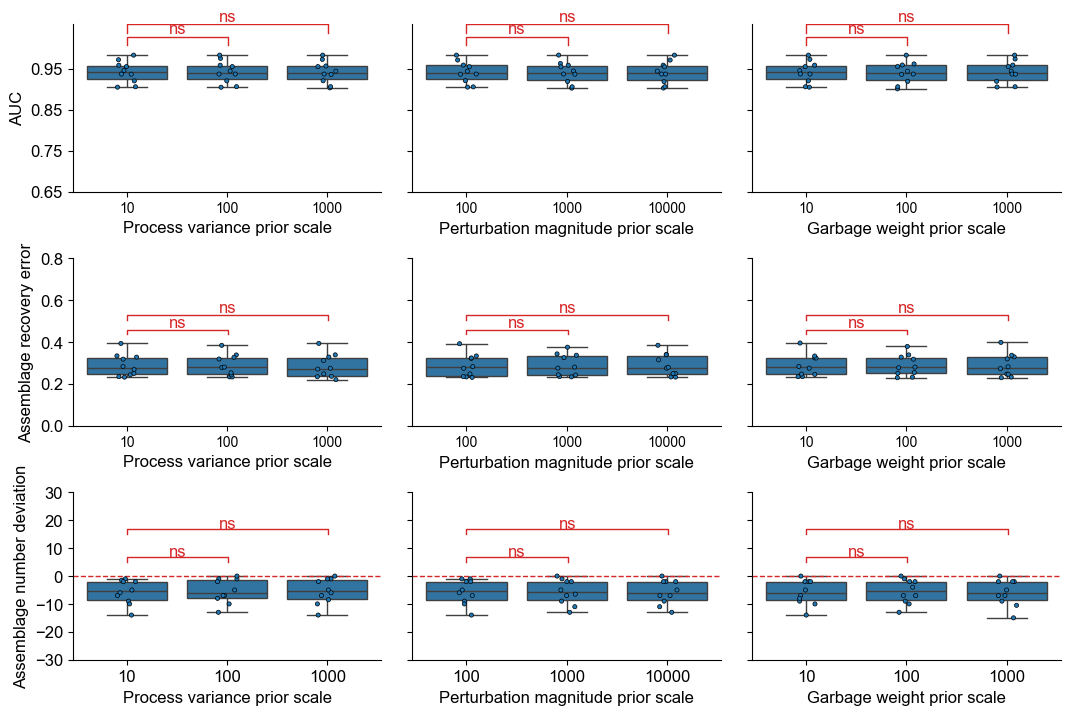

In [ ]:
fontsize=12
label_fontsize=12
ticklabel_fontsize=12

scale = 1.5
fig = plt.figure(figsize=(scale*8.5,0.5*scale*11))
gs = fig.add_gridspec(ncols=1,nrows=3, wspace=0.25, hspace=0.4)

hspace = 0.2
wspace = 0.1
ncols =len(cases)
gspw, axpw = make_sub_gs_ax_cols(fig,gs,0,0,ncols,wspace)
gsar, axar = make_sub_gs_ax_cols(fig,gs,1,0,ncols,wspace)
gsnk, axnk = make_sub_gs_ax_cols(fig,gs,2,0,ncols,wspace)

# plot pairwise results ======================================
axpw, pw_pvals = plot_results(axpw, pwres, cases, 'auc')
for idx,ax in enumerate(axpw):
    ax.set_xlabel(case_names[idx], fontsize=fontsize)
    ax.set_ylim(0.65,1.058)
    ax.set_yticks(np.arange(0.65,1.001,0.1))
    ax=box_to_ell_axes(ax)
    adjpvals = compute_corrected_pvalues_single_cond(pwres, cases[idx], 'auc', base_params[idx])
    ax = annotate_pvalues_single_cond(pwres,cases[idx],'auc', adjpvals, ax,
                                         h=0.02, width=1, text_h=0.02, offset=0.03)
axpw[0].set_ylabel("AUC", fontsize=fontsize)
axpw[0].set_yticklabels(axpw[0].get_yticklabels(), fontsize=ticklabel_fontsize)
for i in [1,2]:
    axpw[i].set_yticklabels("") #labels(axpw[0].get_yticklabels(), fontsize=ticklabel_fontsize)
    axpw[i].set_ylabel("")


# plot comm err results ======================================
axar, ar_pvals = plot_results(axar, arres, cases, 'community error')

for idx,ax in enumerate(axar):
    ax.set_xlabel(case_names[idx], fontsize=fontsize)
    ax.set_ylim(0,0.8)
    ax=box_to_ell_axes(ax)
    adjpvals = compute_corrected_pvalues_single_cond(arres, cases[idx], 'community error', base_params[idx])
    ax = annotate_pvalues_single_cond(arres,cases[idx],'community error', adjpvals, ax,
                                         h=0.02, width=1, text_h=0.02, offset=0.07)

axar[0].set_ylabel("Assemblage recovery error", fontsize=fontsize)
axar[0].set_yticklabels(axar[0].get_yticklabels(), fontsize=ticklabel_fontsize)
for i in [1,2]:
    axar[i].set_yticklabels("")
    axar[i].set_ylabel("")

# plot nk err results ======================================
axnk, nk_pvals = plot_results(axnk, arres, cases, 'number clusters error')
for idx,ax in enumerate(axnk):
    ax.set_xlabel(case_names[idx], fontsize=fontsize)
    ax.axhline(y=0, color='tab:red', linestyle='--', linewidth=1)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=ticklabel_fontsize) #, rotation=rotation)

    ax.set_ylim(-30,30)
    ax=box_to_ell_axes(ax)
    adjpvals = compute_corrected_pvalues_single_cond(arres, cases[idx], 'number clusters error', base_params[idx])
    ax = annotate_pvalues_single_cond(arres,cases[idx],'number clusters error', adjpvals, ax,
                                         h=2.0, width=1, text_h=1.0, offset=10.0)

axnk[0].set_ylabel("Assemblage number deviation", fontsize=fontsize)
axnk[0].set_yticklabels(axnk[0].get_yticklabels(), fontsize=ticklabel_fontsize)
for i in [1,2]:
    axnk[i].set_yticklabels("")
    axnk[i].set_ylabel("")
plt.savefig(outpath / "sensitivity_analysis.svg", bbox_inches="tight")